http://users.eecs.northwestern.edu/~jwa368/pdfs/deep_ranking.pdf

https://github.com/paucarre/tiefvision

https://www.cs.cornell.edu/~kb/publications/SIG15ProductNet.pdf

https://github.com/maestrojeong/t-SNE/blob/master/t-SNE.ipynb

http://cs.stanford.edu/people/karpathy/cnnembed/

http://scikit-learn.org/stable/modules/manifold.html#t-sne

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output

%matplotlib inline

# MNIST data

In [2]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

data_size = len(mnist.train.images)

print(np.shape(mnist.train.images))
print(np.shape(mnist.train.labels))

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
(55000, 784)
(55000, 10)


[[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


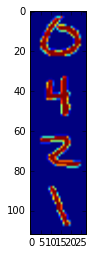

In [3]:
def get_batch(bs):
    idx1 = np.random.choice(data_size, bs)
    idx2 = np.random.choice(data_size, bs)
    
    img1 = mnist.train.images[idx1]
    img2 = mnist.train.images[idx2]
    cls1 = mnist.train.labels[idx1]
    cls2 = mnist.train.labels[idx2]
        
    return img1, cls1, img2, cls2

# test data
img,cls,_,_ = get_batch(4)
img = img.reshape([4*28,28])
plt.imshow(img);
print(cls)
print(img)

# Network
loss: https://academo.org/demos/3d-surface-plotter/?expression=abs(x)%2Fabs(y)%2Babs(y)%2Fabs(x)&xRange=-50%2C+50&yRange=-50%2C+50&resolution=25


In [47]:
input_size = 28*28
class_num = 10

embedding_size = 2

tf.reset_default_graph()
graph = tf.Graph()

with graph.as_default():
    
    image1 = tf.placeholder(tf.float32, [None, input_size])
    image2 = tf.placeholder(tf.float32, [None, input_size])
    class1 = tf.placeholder(tf.float32, [None, class_num])
    class2 = tf.placeholder(tf.float32, [None, class_num])

    def Network1(inputs):
        embeddings = tf.Variable(tf.random_uniform([input_size, embedding_size], -1.0, 1.0), "embeddings")
        outputs = tf.matmul(inputs, embeddings)
        return outputs
    
    def Network2(inputs):
        inputs =  tf.reshape(inputs, [-1, 28, 28, 1])
        l = tf.layers.conv2d(
            inputs=inputs,
            filters=16,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        l = tf.layers.conv2d(
            inputs=l,
            filters=64,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=200, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=embedding_size)
        return l

        
    def Network3(inputs):
        l =  tf.reshape(inputs, [-1, 28, 28, 1])
        
        l = tf.layers.conv2d(
            inputs=l,
            filters=16,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = tf.layers.conv2d(
            inputs=l,
            filters=32,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = tf.layers.conv2d(
            inputs=l,
            filters=64,
            kernel_size=[3, 3],
            padding="same",
            activation=tf.nn.relu)
        l = tf.layers.max_pooling2d(l, pool_size=[2, 2], strides=2)
        
        l = tf.contrib.layers.flatten(l)
        l = tf.layers.dense(l, units=200, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=embedding_size)
        return l

    def Network4(inputs):
        l = inputs
        l = tf.contrib.layers.flatten(l)
        # l = tf.layers.dense(l, units=200, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=300, activation=tf.nn.relu)
        l = tf.layers.dense(l, units=embedding_size)
        return l

    def Loss1(e1, c1, e2, c2):
        e = 1e-6
        same = tf.reduce_sum(c1*c2, axis=1)
        d = tf.sqrt(tf.reduce_sum((e1-e2)**2, axis=1) + e)
        l_same = 0 * tf.reduce_mean(same*d)
        l_diff = 100 * tf.reduce_mean((1-same)/d)
        l_dist = 1 * (tf.reduce_mean(d) - 1)**2
        return l_same + l_diff + l_dist

    
    Embedding = Network3
    Loss = Loss1
    
    embed1 = Embedding(image1)
    embed2 = Embedding(image2)    
    
    loss = Loss(embed1,class1,embed2,class2)
    optimizer = tf.train.AdamOptimizer(0.1).minimize(loss)

# Let's train

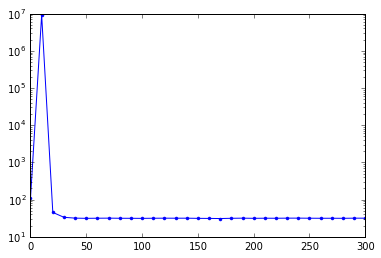

CPU times: user 32.8 s, sys: 8.6 s, total: 41.4 s
Wall time: 30.1 s


In [48]:
%%time
num_steps = 300
batch_size = 128

with tf.Session(graph=graph) as sess:
    try:
        tf.global_variables_initializer().run()
        print('Initialized')
        average_loss = 0

        history = []
        for step in range(num_steps+1):
            img1, cls1, img2, cls2 = get_batch(batch_size)
            _, current_loss = sess.run([optimizer, loss], feed_dict = {
                image1 : img1,
                image2 : img2,
                class1 : cls1,
                class2 : cls2,

            })
            average_loss += current_loss
            every = 10
            if step % every == 0:
                average_loss = average_loss / every
                history.append([step,average_loss])
                clear_output(True)
                plt.yscale('log')
                plt.plot(*zip(*history),marker='.')
                plt.show()
                # print("step:%4d,  loss: %.2e"%(step, average_loss))
                average_loss = 0
    except KeyboardInterrupt:
        pass
    img, img_labels, _, _ = get_batch(1000)
    labels = np.argmax(img_labels, axis=1)
    embeds = sess.run([embed1], feed_dict = {image1 : img1})[0]

# SVD Visualization

points (70, 2)


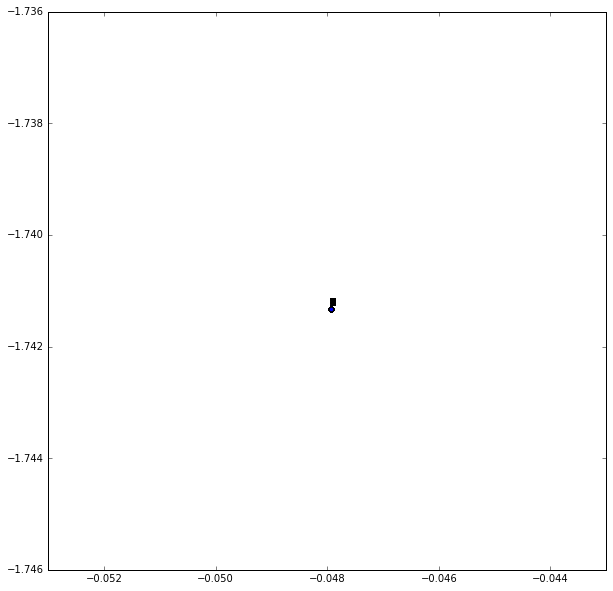

In [45]:
from sklearn.manifold import TSNE

num_points = 70
points = embeds[:num_points]

print('points', np.shape(points))

# two_d_embeddings = np.linalg.svd(points)[0]
two_d_embeddings = points

plt.figure(figsize=(10,10))

for i in range(num_points):
    x, y = two_d_embeddings[i, :2]
    plt.scatter(x, y)
    plt.annotate(labels[i], xy=(x, y), xytext=(5, 2), textcoords="offset points",
    ha="right", va="bottom")
plt.show();

# TSNE Visualization

/usr/local/lib/python3.5/dist-packages/sklearn/decomposition/pca.py:501: RuntimeWarning: divide by zero encountered in true_divide
  self.explained_variance_ / total_var.sum()


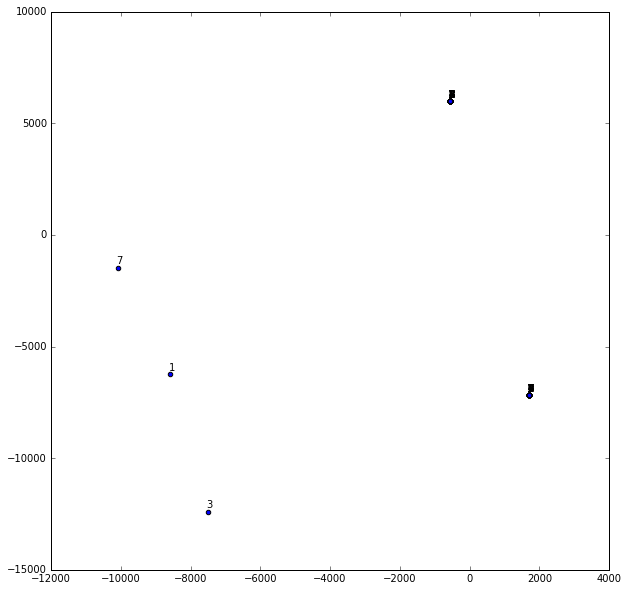

In [41]:
from sklearn.manifold import TSNE

points = embeds[:num_points]

two_d_embeddings = TSNE(perplexity=10, n_components=2, init="pca", n_iter=5000).fit_transform(points)

plt.figure(figsize=(10,10))

for i in range(num_points):
    x, y = two_d_embeddings[i, :2]
    plt.scatter(x, y)
    plt.annotate(labels[i], xy=(x, y), xytext=(5, 2), textcoords="offset points",
    ha="right", va="bottom")
plt.show();

# Test similarities